# CS 180 project 5: Neural Radiance Field!


In [30]:
!pip install pillow
!pip install viser
!pip install imageio

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import math
from PIL import Image
import tqdm
from torch.utils.tensorboard import SummaryWriter
import viser, time
import imageio

In [3]:
# Mounting Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Helper functions
def save_model(model, file_path):
    """
    Save a PyTorch model to a file.

    Args:
        model: The PyTorch model to be saved.
        file_path: The file path where the model will be saved: (model.pth)
    """
    try:
        torch.save(model.state_dict(), file_path)
        print(f"Model saved to {file_path}")
    except Exception as e:
        print(f"An error occurred while saving the model: {str(e)}")

# TODO
def save_image(image, path):
  pass

## Part 1:  Fit a Neural Field to a 2D Image

### Network

In [5]:
class PositionalEncoding(nn.Module):
    def __init__(self, L=10):
        super(PositionalEncoding, self).__init__()
        self.L = L

    def forward(self, x):
        PE = [x]
        for i in range(self.L):
            PE.append(torch.sin(2.0 ** i * math.pi * x))
            PE.append(torch.cos(2.0 ** i * math.pi * x))
        PE = torch.cat(PE, dim=-1)
        return PE

class MLP(nn.Module):
    def __init__(self, L=10, input_dim=42, output_dim=3, hidden_dim=256):
        super(MLP, self).__init__()
        self.positional_encoding = PositionalEncoding(L)

        self.mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.positional_encoding(x)
        x = self.mlp(x)
        return x


### DataLoader


In [6]:
class ImageDataset(Dataset):
    def __init__(self, image, N=10000):
        self.image = image
        self.width, self.height = self.image.size
        self.N = N

    def __len__(self):
        return self.N

    def __getitem__(self):
        x = np.random.randint(0, self.width)
        y = np.random.randint(0, self.height)

        coordinate = torch.tensor([x/self.width, y/self.height], dtype=torch.float32)

        pixel_value = self.image.getpixel((x, y))
        color = torch.tensor(pixel_value, dtype=torch.float32) / 255.0

        return coordinate, color

### Training and Tuning

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [8]:
def calculate_psnr(mse_loss):
    return 10 * math.log10(1 / mse_loss)

def create_image_coordinates(height, width):
    x, y = np.meshgrid(np.arange(width), np.arange(height))
    coordinates = np.column_stack((x.flatten(), y.flatten()))
    return torch.tensor(coordinates, dtype=torch.float32)

# Instantiation
L = 10 # Hyperparameter 1
lr = 0.001 # Hyperparameter 2
hidden_dim = 512 # Hyperparameter 3


tb_writer = SummaryWriter(log_dir="/content/drive/MyDrive/CS180proj5/Logs/Part1")
psnr_list = []
model = MLP(input_dim=L*4 + 2, L=L, hidden_dim=hidden_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_function = nn.MSELoss()

# Opening image
image_path = "/content/drive/MyDrive/CS180proj5/Data/comics.jpg"
image = Image.open(image_path)
width, height = image.size
all_coordinates = create_image_coordinates(height, width) / torch.tensor([width, height], dtype=torch.float32)

# Training loop
num_iters = 2000
for iter in range(num_iters):
    dataset = ImageDataset(image)
    dataloader = DataLoader(dataset, batch_size=128, shuffle=False)

    progress_bar = tqdm.tqdm(dataloader)

    for i, data in enumerate(progress_bar):
        coordinates, colors = data
        coordinates = coordinates.to(device)
        colors = colors.to(device)

        optimizer.zero_grad()

        outputs = model(coordinates)
        loss = loss_function(outputs, colors)

        loss.backward()
        optimizer.step()

        # global_step = epoch * len(dataloader) + i
        # tb_writer.add_scalar("loss", loss.item(), global_step)
        # progress_bar.set_description(f"Loss: {loss}")

    # Calculate and print PSNR every 100 epochs
    if iter % 400 == 0 or iter == num_iters-1:
        with torch.no_grad():
            model.eval()

            true_colors = torch.tensor(image.getdata(), dtype=torch.float32) / 255.0
            predicted_colors = model(all_coordinates.to(device))
            full_loss = loss_function(predicted_colors, true_colors.to(device))

            psnr = calculate_psnr(full_loss.item())
            print(f"Epoch [{iter}/{num_iters}], PSNR: {psnr}")
            psnr_list.append((iter, psnr))

            predicted_colors = predicted_colors.cpu().numpy()
            predicted_colors = predicted_colors.reshape(height, width, 3)
            plt.imshow(predicted_colors)
            plt.title(f"Epoch: {iter}, LR: {lr}, Channel Size: {hidden_dim}")
            plt.axis("off")
            plt.savefig(f"/content/drive/MyDrive/CS180proj5/Output/comics_{iter}_{lr}_{hidden_dim}.jpg")
            plt.show()

            model.train()

print("Finished")

iterations, psnr_values = zip(*psnr_list)

plt.figure(figsize=(10, 5))
plt.plot(iterations, psnr_values, marker='o')
plt.title(f'PSNR, LR: {lr}, Channel Size: {hidden_dim}')
plt.xlabel('Iteration')
plt.ylabel('PSNR')
plt.grid(True)
plt.savefig(f"/content/drive/MyDrive/CS180proj5/Output/comics_psnrPlot_{iter}_{lr}_{hidden_dim}.jpg")
plt.show()


KeyboardInterrupt: ignored

## Part 2: Fit a Neural Radiance Field from Multi-view Images

In [8]:
data = np.load(f"/content/drive/MyDrive/CS180proj5/Data/lego_200x200.npz")

# Training images: [100, 200, 200, 3]
images_train = data["images_train"]

# Cameras for the training images
# (camera-to-world transformation matrix): [100, 4, 4]
c2ws_train = data["c2ws_train"]

# Validation images:
images_val = data["images_val"]

# Cameras for the validation images: [10, 4, 4]
# (camera-to-world transformation matrix): [10, 200, 200, 3]
c2ws_val = data["c2ws_val"]

# Test cameras for novel-view video rendering:
# (camera-to-world transformation matrix): [60, 4, 4]
c2ws_test = data["c2ws_test"]

# Camera focal length
focal = data["focal"]  # float

### Part 2.1: Create Rays from Cameras

In [9]:
# Camera to world space conversion
def transform(c2ws, xcs):
    '''
    Input:
    xcs: N x 3 array of camera coordinates
    c2ws: N x 4 x 4 array of camera-to-world matrices

    Output:
    x_w: N x 3 array of world coordinates
    '''
    ones = np.ones(len(xcs)).reshape(len(xcs), 1)
    x_c_homogeneous = np.append(xcs, ones, axis=1)
    x_w_homogeneous = np.einsum('nij,nj->ni', c2ws, x_c_homogeneous)
    x_w = x_w_homogeneous[:, :3] / x_w_homogeneous[:, 3][:, np.newaxis]

    return x_w

x = np.array([[1., 2., 3.], [4., 5., 6.]])
c2w = np.array([[[0.866, -0.5, 0, 1],
                [0.5, 0.866, 0, 2],
                [0, 0, 1, 3],
                [0, 0, 0, 1]]])

print(np.allclose(x, transform(np.linalg.inv(c2w), transform(c2w, x))))

# Pixel to camera coordinate conversion
def pixel_to_camera(K, uvs, s):
    '''
    Input:
    K: 3 x 3 intrinsic matrix
    uvs: N x 2 array of pixel points
    s: N array of depths

    Output:
    x_c: N x 3 array of camera coordinates
    '''
    K_inv = np.linalg.inv(K)
    ones = np.ones(len(uvs)).reshape(len(uvs), 1)
    uvs_homogeneous = np.append(uvs, ones, axis=1)
    uv_homogeneous = uvs_homogeneous * s[:, np.newaxis]
    x_c = np.dot(uv_homogeneous, K_inv.T)

    return x_c

# Pixel to ray
def pixel_to_ray(K, c2ws, uvs):
    '''
    Input:
    K: 3 x 3 intrinsic matrix
    uvs: N x 2 array of pixel points
    c2ws: N x 4 x 4 array of camera-to-world matrices

    Output:
    r_o: N x 3 array of origin rays
    r_d: N x 3 array of direction rays
    '''
    s = np.ones(len(uvs))
    x_cs = pixel_to_camera(K, uvs, s)
    x_ws = transform(c2ws, x_cs)
    w2cs = np.linalg.inv(c2ws)

    R_3x3 = w2cs[:, :3, :3]
    t = w2cs[:, :3, 3]

    r_o = -np.einsum('nij,nj->ni', np.linalg.inv(R_3x3), t)

    r_d = x_ws - r_o
    r_d = r_d / np.linalg.norm(r_d, axis=1)[:, None]

    return r_o, r_d



True


### Part 2.2: Sampling

In [10]:
# Sampling Rays from Images
def sample_rays(images, K, c2ws, num_rays):
    height, width, _ = images[0].shape
    num_images = len(images)

    indices = np.random.choice(width * height * num_images, num_rays, replace=False)

    # Convert indices to 3D indices: (image index, pixel row, pixel column)
    image_indices, pixel_indices = np.divmod(indices, width * height)
    u, v = np.unravel_index(pixel_indices, (height, width))

    uv = np.stack([u, v], axis=-1) + 0.5

    # Expand c2ws
    expanded_c2ws = c2ws[image_indices]

    # Compute all rays at once
    all_rays_o, all_rays_d = pixel_to_ray(K, expanded_c2ws, uv)

    # Sample colors
    colors = images[image_indices, u, v] / 255.0

    return all_rays_o, all_rays_d, colors

# Sampling Points along Rays
def sample_along_rays(rays_o, rays_d, perturb=True):
    num_samples = rays_d.shape[1]
    near, far = 2.0, 6.0

    # Uniform linspace for each ray
    t = np.linspace(near, far, num_samples)

    # Random perturbation
    if perturb:
        t += np.random.uniform(0, (far - near) / num_samples, size=num_samples)

    # Repeat t for each ray and reshape to [N_rays, n_samples, 1]
    t = np.tile(t, (rays_o.shape[0], 1)).reshape(rays_o.shape[0], num_samples, 1)

    # Calculate the 3D coordinates
    # ray_origins[:, None, :] shape: [N_rays, 1, 3], broadcasting to [N_rays, n_samples, 3]
    # ray_directions[:, None, :] shape: [N_rays, 1, 3], broadcasting to [N_rays, n_samples, 3]
    x = rays_o[:, :, :] + rays_d[:, :, :] * torch.tensor(t)  # shape: [N_rays, n_samples, 3]

    return x



### Part 2.3: Putting the Dataloading All Together

In [11]:
class RaysData(Dataset):
    def __init__(self, images, K, c2ws, near=2.0, far=6.0):
        self.images = images
        self.K = K
        self.c2ws = c2ws
        self.near = near
        self.far = far

    def sample_rays(self, num_rays, num_samples, specific_image_idx=-1, sample_whole_image=False):
        height, width, _ = self.images[0].shape
        num_images = len(self.images)

        if specific_image_idx == -1:
            indices = np.random.choice(width * height * num_images, num_rays, replace=False)

            # Convert indices to 3D indices: (image index, pixel row, pixel column)
            image_indices, pixel_indices = np.divmod(indices, width * height)
            v, u = np.unravel_index(pixel_indices, (height, width))

            uv = np.stack([u, v], axis=-1) + 0.5

            # Expand c2ws
            expanded_c2ws = self.c2ws[image_indices]

            # Compute all rays at once
            all_rays_o, all_rays_d = pixel_to_ray(self.K, expanded_c2ws, uv)
            all_rays_o, all_rays_d = all_rays_o.reshape(num_rays, 1, 3), all_rays_d.reshape(num_rays, 1, 3)

            # Repeat value along dimension 1
            all_rays_o = np.repeat(all_rays_o, num_samples, axis=1)
            all_rays_d = np.repeat(all_rays_d, num_samples, axis=1)

            # Sample colors
            colors = self.images[image_indices, v, u] / 255.0

        else:
            if not sample_whole_image:
                indices = np.random.choice(width * height, num_rays, replace=False)

                v, u = np.unravel_index(indices, (height, width))

                uv = np.stack([u, v], axis=-1) + 0.5

                c2ws = self.c2ws[specific_image_idx]
                c2ws = c2ws[np.newaxis, :, :]

                all_rays_o, all_rays_d = pixel_to_ray(self.K, c2ws, uv)
                all_rays_o = np.tile(all_rays_o, (all_rays_d.shape[0], 1))

                all_rays_o, all_rays_d = all_rays_o.reshape(num_rays, 1, 3), all_rays_d.reshape(num_rays, 1, 3)

                # Repeat value along dimension 1
                all_rays_o = np.repeat(all_rays_o, num_samples, axis=1)
                all_rays_d = np.repeat(all_rays_d, num_samples, axis=1)

                colors = self.images[specific_image_idx, v, u] / 255.0

            else:
                v, u = np.meshgrid(np.arange(height), np.arange(width), indexing='ij')

                uv = np.stack([u.flatten(), v.flatten()], axis=-1) + 0.5

                c2ws = self.c2ws[specific_image_idx]
                c2ws = c2ws[np.newaxis, :, :]

                all_rays_o, all_rays_d = pixel_to_ray(self.K, c2ws, uv)

                num_rays = all_rays_d.shape[0]
                all_rays_o = np.tile(all_rays_o, (num_rays, 1))

                all_rays_o, all_rays_d = all_rays_o.reshape(num_rays, 1, 3), all_rays_d.reshape(num_rays, 1, 3)

                # Repeat value along dimension 1
                all_rays_o = np.repeat(all_rays_o, num_samples, axis=1)
                all_rays_d = np.repeat(all_rays_d, num_samples, axis=1)

                colors = self.images[specific_image_idx, v, u] / 255.0
                colors = colors.reshape(-1, 3)

                # Sanity check
                # image = self.images[specific_image_idx]

                # # Flatten the image to a 2D array where each row is a pixel's RGB values
                # flattened_image = image.reshape(-1, 3)

                # # Iterate over each pair of UV coordinates
                # for i, (u_coord, v_coord) in enumerate(uv):
                #     # Convert the UV coordinates to integer pixel indices
                #     u_idx, v_idx = int(u_coord), int(v_coord)

                #     # Retrieve the color from the flattened image using the linear index
                #     image_color = flattened_image[v_idx * 200 + u_idx] / 255.0

                #     # Retrieve the corresponding color from the colors array
                #     colors_color = colors[i, :]

                #     # Check if the colors match
                #     if not np.allclose(image_color, colors_color):
                #         print(f"Mismatch found at index {i}: Image color {image_color}, Colors array color {colors_color}")
                #         break
                # else:
                #     print("Sanity check passed: All UVs map correctly to pixels.")




        return torch.tensor(all_rays_o), torch.tensor(all_rays_d), torch.tensor(colors)



In [29]:
# Sanity check: Generate rays for every pixel and correct formatting
H, W = images_train.shape[1:3]
K = np.array([[focal, 0, W/2], [0, focal, H/2], [0, 0, 1]])
dataset = RaysData(images_train, K, c2ws_train)
rays_o, rays_d, pixels = dataset.sample_rays(40000, 64, specific_image_idx=0, sample_whole_image=True)

In [14]:
# Sanity check: Generate 100 rays from a single image camera
H, W = images_train.shape[1:3]
K = np.array([[focal, 0, W/2], [0, focal, H/2], [0, 0, 1]])
dataset = RaysData(images_train, K, c2ws_train)
rays_o, rays_d, pixels = dataset.sample_rays(100, 64, specific_image_idx=0)
points = sample_along_rays(rays_o, rays_d, perturb=True)
points = points.numpy()
# ---------------------------------------

server = viser.ViserServer(share=True)
for i, (image, c2w) in enumerate(zip(images_train, c2ws_train)):
    server.add_camera_frustum(
        f"/cameras/{i}",
        fov=2 * np.arctan2(H / 2, K[0, 0]),
        aspect=W / H,
        scale=0.15,
        wxyz=viser.transforms.SO3.from_matrix(c2w[:3, :3]).wxyz,
        position=c2w[:3, 3],
        image=image
    )

single_rays_o = rays_o[:, 0, :]
single_rays_d = rays_d[:, 0, :]

for i, (o, d) in enumerate(zip(single_rays_o, single_rays_d)):
    server.add_spline_catmull_rom(
        f"/rays/{i}", positions=np.stack((o, o + d * 6.0)),
    )
server.add_point_cloud(
    f"/samples",
    colors=np.zeros_like(points).reshape(-1, 3),
    points=points.reshape(-1, 3),
    point_size=0.02,
)
time.sleep(1000)

torch.Size([100, 3])


(viser) Share URL requested! (expires in 24 hours)

╭───────────────────────── viser ──────────────────────────╮
│             ╷                                            │
│   HTTP      │ http://0.0.0.0:8081                        │
│   Websocket │ ws://0.0.0.0:8081                          │
│   Share URL │ https://softmax-recur.share.viser.studio   │
│             ╵                                            │
╰──────────────────────────────────────────────────────────╯

(viser) Connection opened (0, 1 total), 405 persistent messages

(viser) Connection closed (0, 0 total)

KeyboardInterrupt: ignored

In [36]:
# Code for testing dataloader and visualizing rays and samples
# --- You Need to Implement These ------
H, W = images_train.shape[1:3]
K = np.array([[focal, 0, W/2], [0, focal, H/2], [0, 0, 1]])
dataset = RaysData(images_train, K, c2ws_train)
rays_o, rays_d, pixels = dataset.sample_rays(100, 64)
points = sample_along_rays(rays_o, rays_d, perturb=True)
points = points.numpy()
# ---------------------------------------

server = viser.ViserServer(share=True)
for i, (image, c2w) in enumerate(zip(images_train, c2ws_train)):
    server.add_camera_frustum(
        f"/cameras/{i}",
        fov=2 * np.arctan2(H / 2, K[0, 0]),
        aspect=W / H,
        scale=0.15,
        wxyz=viser.transforms.SO3.from_matrix(c2w[:3, :3]).wxyz,
        position=c2w[:3, 3],
        image=image
    )

single_rays_o = rays_o[:, 0, :]
single_rays_d = rays_d[:, 0, :]

for i, (o, d) in enumerate(zip(single_rays_o, single_rays_d)):
    server.add_spline_catmull_rom(
        f"/rays/{i}", positions=np.stack((o, o + d * 6.0)),
    )
server.add_point_cloud(
    f"/samples",
    colors=np.zeros_like(points).reshape(-1, 3),
    points=points.reshape(-1, 3),
    point_size=0.02,
)
time.sleep(1000)

(viser) Share URL requested! (expires in 24 hours)

╭──────────────────────────── viser ─────────────────────────────╮
│             ╷                                                  │
│   HTTP      │ http://0.0.0.0:8082                              │
│   Websocket │ ws://0.0.0.0:8082                                │
│   Share URL │ https://polarize-calibrated.share.viser.studio   │
│             ╵                                                  │
╰────────────────────────────────────────────────────────────────╯

(viser) Connection opened (0, 1 total), 405 persistent messages

(viser) Connection closed (0, 0 total)

KeyboardInterrupt: ignored

### Part 2.4: Neural Radiance Field


In [12]:
# Input: 3D world coordinates, 3D ray direction
class NeRFNetwork(nn.Module):
    def __init__(self, D=7, W=256, input_ch=3, L_pos=10, L_dir=4):
        """
        D: number of intermediate layers
        W: number of neurons per layer
        input_ch: number of input channels (3 for the positional encoding of xyz)
        L_pos: frequency levels for position
        L_dir: frequency levels for direction
        """
        super(NeRFNetwork, self).__init__()
        self.L_pos = L_pos
        self.L_dir = L_dir
        self.D = D
        self.input_ch = input_ch
        self.W = W

        # Positional encoding for positions and directions
        self.positional_encoding = PositionalEncoding(L=L_pos)
        self.directional_encoding = PositionalEncoding(L=L_dir)

        # Initial linear layer
        self.initial_linear = nn.Linear(input_ch * (2 * L_pos + 1), W)

        # Regular linear layer
        self.linear = nn.Linear(W, W)

        # Intermediate linear layers
        self.intermediate_linears = nn.ModuleList([nn.Linear(W, W), nn.Linear(W, W), nn.Linear(W, W),
                                                   nn.Linear(W + input_ch * (2 * L_pos + 1), W), nn.Linear(W, W), nn.Linear(W, W)])

        # Final linear layers for color and density
        self.color_linear = nn.Sequential(
            nn.Linear(W + input_ch * (2 * L_dir + 1), W // 2),
            nn.ReLU(True),
            nn.Linear(W // 2, 3),
            nn.Sigmoid()
        )
        self.density_linear = nn.Sequential(
            nn.Linear(W, 1),
            nn.ReLU(True)
        )

    def forward(self, x, view_dir):
        encoded_x = self.positional_encoding(x)
        encoded_dir = self.directional_encoding(view_dir)

        # Initial linear layer
        x = F.relu(self.initial_linear(encoded_x))

        # Intermediate layers
        for idx, layer in enumerate(self.intermediate_linears):
            x = F.relu(layer(x))
            if idx == 2:
                x = torch.cat((x, encoded_x), -1)  # Skip connection

        # Final linear layer before split
        x = self.linear(x)

        # Predict density
        density = self.density_linear(x)

        # Predict color
        x = self.linear(x)
        x = torch.cat((x, encoded_dir), -1)  # Skip connection
        color = self.color_linear(x)

        return density, color


### Part 2.5: Volume Rendering

In [13]:
def volrend(sigmas, rgbs, step_size):
    sigmas = sigmas.to(dtype=torch.float32)
    rgbs = rgbs.to(dtype=torch.float32)

    # Calculate the transmittance T_i by taking the cumulative product of 1 - alpha
    # where alpha is the probability of terminating at sample location i
    delta_i = torch.ones_like(sigmas) * step_size
    alpha = 1 - torch.exp(-sigmas * delta_i)  # Shape: [N_rays, n_samples, 1]
    T_i = torch.cumprod(torch.cat([torch.ones_like(sigmas[:, :1]), 1 - alpha[:, :-1]], dim=1), dim=1)

    # Calculate the weighted colors
    weights = alpha * T_i  # Shape: [N_rays, n_samples, 1]
    colors = weights * rgbs  # Shape: [N_rays, n_samples, 3]

    # Sum along the sample dimension to get the final color per ray
    rendered_colors = colors.sum(dim=1)  # Shape: [N_rays, 3]

    return rendered_colors

torch.manual_seed(42)
sigmas = torch.rand((10, 64, 1)) * 1000
rgbs = torch.rand((10, 64, 3))
step_size = (6.0 - 2.0) / 64
rendered_colors = volrend(sigmas, rgbs, step_size)

correct = torch.tensor([
  [0.6020, 0.0316, 0.9366],
  [0.0620, 0.2249, 0.1381],
  [0.7785, 0.4253, 0.7124],
  [0.8748, 0.5055, 0.7411],
  [0.2240, 0.5240, 0.4298],
  [0.0531, 0.7500, 0.0501],
  [0.0458, 0.9415, 0.4620],
  [0.6692, 0.3450, 0.0991],
  [0.7392, 0.6365, 0.3080],
  [0.2425, 0.9346, 0.9305]]
)

assert torch.allclose(rendered_colors, correct, rtol=1e-4, atol=1e-4)


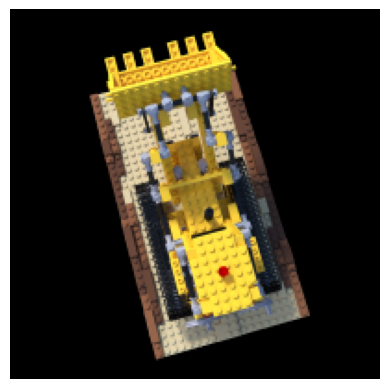

In [16]:
plt.imshow(images_val[0])
plt.axis('off')
plt.savefig(f"/content/drive/MyDrive/CS180proj5/Output/lego_val_0_GroundTruth.jpg")
plt.show()

### Training and Tuning

Step: 0, Validation PSNR: 11.605513090966452


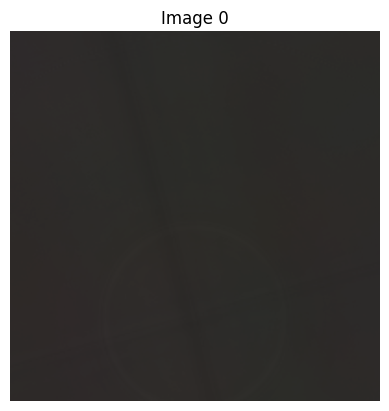

Step: 300, Validation PSNR: 19.412126003225808


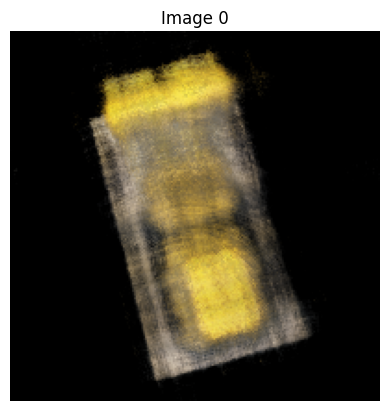

Step: 600, Validation PSNR: 21.294694113074826


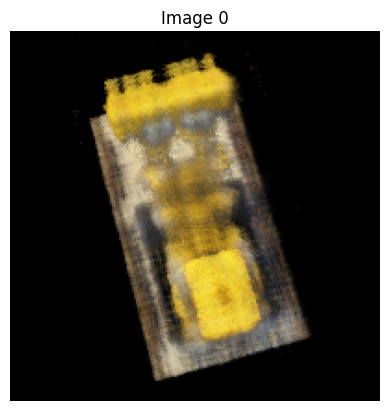

Step: 900, Validation PSNR: 22.405468489144944


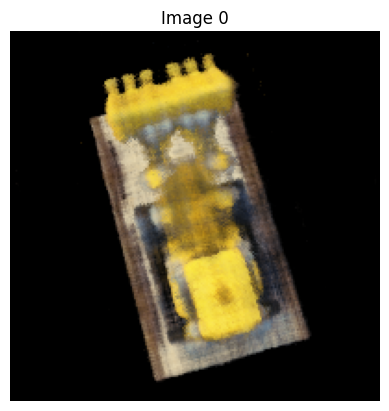

Step: 1200, Validation PSNR: 23.50007078878662


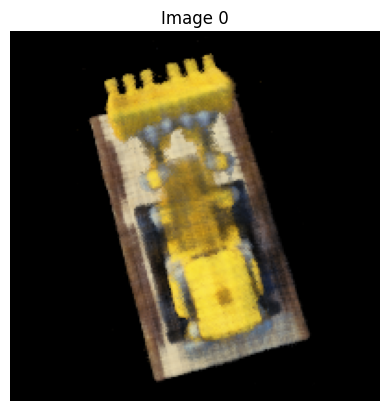

Step: 1500, Validation PSNR: 23.97716972578784


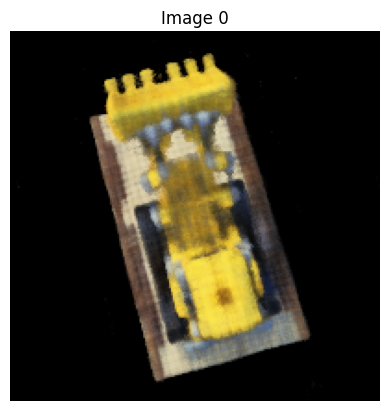

Step: 1800, Validation PSNR: 24.580768242915674


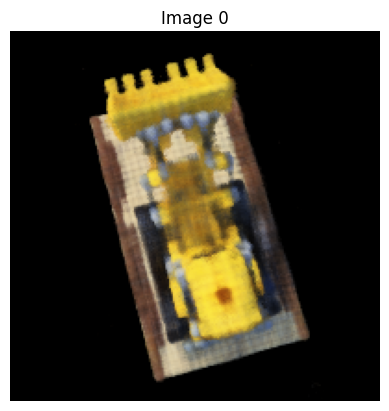

Step: 2100, Validation PSNR: 24.561712632598546


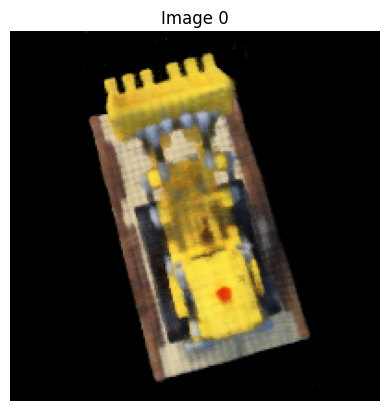

Step: 2400, Validation PSNR: 24.858683175351658


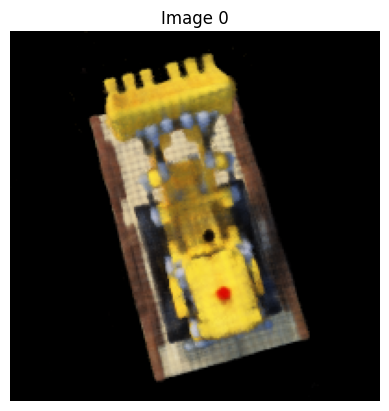

Step: 2700, Validation PSNR: 25.23503667313765


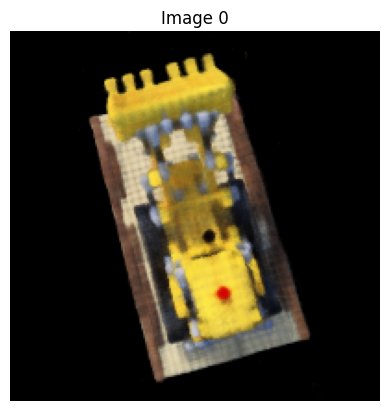

Step: 2999, Validation PSNR: 25.64445788919763


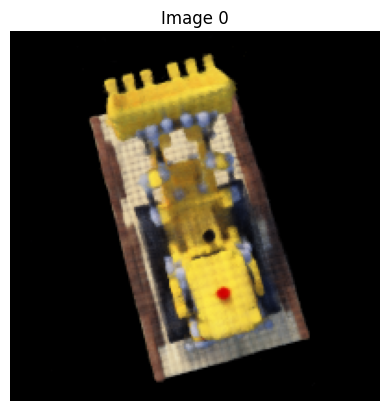

Finished


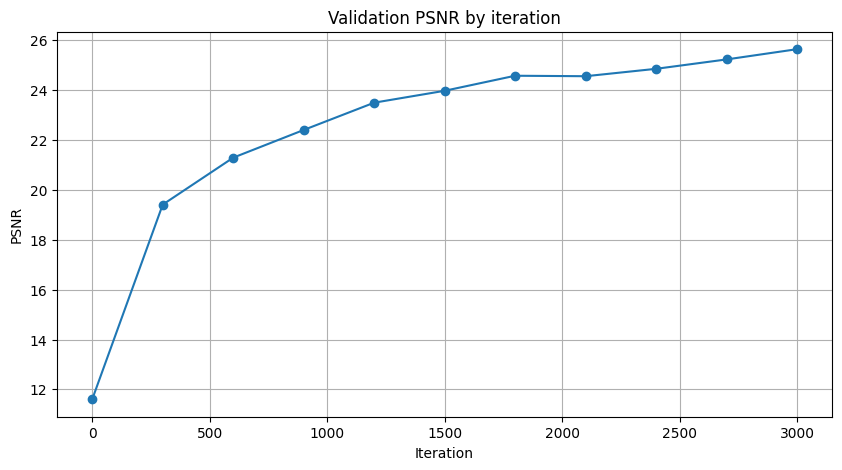

In [20]:
def calculate_psnr(mse_loss):
    return 10 * math.log10(1 / mse_loss)

def validate_model(dataset: RaysData, model: NeRFNetwork, loss_fn):
    psnr=0
    rays_o, rays_d, colors_gt = dataset.sample_rays(batch_size, 64, specific_image_idx=0, sample_whole_image=True)
    points = sample_along_rays(rays_o, rays_d, perturb=False)
    densities, colors = model(points.to(device).float(), rays_d.to(device).float())
    predicted_colors = volrend(densities, colors, step_size=(6.0 - 2.0)/points.shape[1])
    loss = loss_fn(predicted_colors, colors_gt.to(device).float())
    psnr += calculate_psnr(loss)
    image = predicted_colors.cpu().numpy()

    return psnr, image


# Instantiation
L_pos = 10
L_dir = 4
lr = 5e-4

nerf_model = NeRFNetwork().to(device)
optimizer = optim.Adam(nerf_model.parameters(), lr=lr)
loss_function = nn.MSELoss()
tb_writer = SummaryWriter(log_dir="/content/drive/MyDrive/CS180proj5/Logs/Part1")

H, W = images_train.shape[1:3]
K = np.array([[focal, 0, W/2], [0, focal, H/2], [0, 0, 1]])
train_dataset = RaysData(images_train, K, c2ws_train)

val_dataset = RaysData(images_val, K, c2ws_val)

psnr_list = []

num_iters = 3000
batch_size = 10000

# Training and Validation loop
for iter in range(num_iters):
    optimizer.zero_grad()

    # Sampling 10000 random rays and pixels from train dataset
    rays_o, rays_d, gt_colors = train_dataset.sample_rays(batch_size, 64)
    points = sample_along_rays(rays_o, rays_d, perturb=True)

    # Getting densities and colors from NeRF
    densities, colors = nerf_model(points.to(device).float(), rays_d.to(device).float())

    # Volume rendering to get predicted RGB values
    predicted_colors = volrend(densities, colors, step_size=(6.0 - 2.0)/points.shape[1])

    loss = loss_function(predicted_colors, gt_colors.to(device).float())

    loss.backward()
    optimizer.step()

    # Save GPU memory
    points, rays_d, gt_colors = points.detach(), rays_d.detach(), gt_colors.detach()

    # Log PSNR and visualize every few steps
    if iter % 300 == 0 or iter == num_iters - 1:
        with torch.no_grad():
            nerf_model.eval()

            # Sample rays from validation set and calculate PSNR
            psnr, image = validate_model(val_dataset, nerf_model, loss_function)

            print(f'Step: {iter}, Validation PSNR: {psnr}')
            psnr_list.append((iter, psnr))

            # Displaying image
            image = image.reshape(200, 200, 3)
            plt.imshow(image)
            plt.axis('off')  # Turn off axis
            plt.title("Image 0")
            plt.savefig(f"/content/drive/MyDrive/CS180proj5/Output/lego_val_0_{iter}.jpg")
            plt.show()

            nerf_model.train()

print("Finished")

iterations, psnr_values = zip(*psnr_list)

plt.figure(figsize=(10, 5))
plt.plot(iterations, psnr_values, marker='o')
plt.title(f'Validation PSNR by iteration')
plt.xlabel('Iteration')
plt.ylabel('PSNR')
plt.grid(True)
plt.savefig(f"/content/drive/MyDrive/CS180proj5/Output/val_psnrPlot.jpg")
plt.show()


In [22]:
u, v = np.meshgrid(np.arange(200), np.arange(200), indexing='ij')
uv = np.stack([u.flatten(), v.flatten()], axis=-1) + 0.5
print(uv)

[[  0.5   0.5]
 [  0.5   1.5]
 [  0.5   2.5]
 ...
 [199.5 197.5]
 [199.5 198.5]
 [199.5 199.5]]


In [40]:
def generate_novel_view(model, c2ws):
    images = []

    K = np.array([[focal, 0, W/2], [0, focal, H/2], [0, 0, 1]])
    v, u = np.meshgrid(np.arange(200), np.arange(200), indexing='ij')
    uv = np.stack([u.flatten(), v.flatten()], axis=-1) + 0.5
    for i in range(len(c2ws)):
        c2w = c2ws[i]
        c2w = c2w[np.newaxis, :, :]
        rays_o, rays_d = pixel_to_ray(K, c2w, uv)
        rays_o = np.tile(rays_o, (40000, 1))
        rays_o, rays_d = rays_o.reshape(40000, 1, 3), rays_d.reshape(40000, 1, 3)
        rays_o = torch.tensor(np.repeat(rays_o, 64, axis=1))
        rays_d = torch.tensor(np.repeat(rays_d, 64, axis=1))
        points = sample_along_rays(rays_o, rays_d, perturb=False)
        with torch.no_grad():
            model.eval()
            densities, colors = model(points.to(device).float(), rays_d.to(device).float())
            predicted_colors = volrend(densities, colors, step_size=(6.0 - 2.0)/points.shape[1])
            image = predicted_colors.cpu().numpy()
            image = image.reshape(200, 200, 3)
            images.append(image)
    return images

images = generate_novel_view(nerf_model, c2ws_test)

OutOfMemoryError: ignored

In [36]:
images_int = [(img * 255).astype(np.uint8) for img in images]
with imageio.get_writer('/content/drive/MyDrive/CS180proj5/Output/lego.gif', mode='I', duration=0.5) as writer:
    for image in images_int:
        writer.append_data(image)

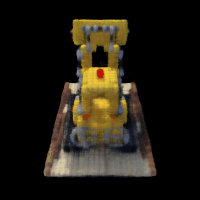

In [39]:
from IPython.display import Image, display

# Display the saved GIF
display(Image(filename='/content/drive/MyDrive/CS180proj5/Output/lego.gif'))